# Feature Extraction

Create Timeseries features to predict the active power of the chopper
- month
- emw
- workday or not
- holiday
- noon
- ...

Also add the mass flow as feature<br>
<br>
Do NOT add the correlation as feature (Syon will make this) -> high correlation between chopper and conveyor belt -> yes/no -> idea: the model can choose the active power by high correlation<br>
<br>
Weather Feature (temperature and precipitation) already got analysed and not got implemented here, because the results looked not promising.

### Imports

In [1]:
# basic data
import numpy as np
import pandas as pd

# helper functions
import IPython
import holidays
from datetime import datetime
import random

# vizulations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# feature creation
from enum import Enum
import meteostat as weather
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from pathlib import Path

### Helper Functions

In [2]:
# !pip install tabulate
def display(df:pd.DataFrame, use_html=True, amount=5, columns=None, reset_index=True, should_return=False, save_to_file=False):
    if amount != None and amount != -1 and amount != "all":
        df = df.sample(min(amount, len(df.index)))

    if reset_index:
        df = df.reset_index(drop=True, inplace=False)

    if columns != None:
        if type(columns) == list or type(columns) == tuple:
            df = df.loc[:, columns]
        else:
            df = df.loc[:, [columns]]

    if save_to_file:
        df.to_markdown('data_display.md', index=not reset_index)
        if should_return:
            return df
        else:
            return

    if use_html:
        if type(df) == pd.Series:
            df = df.to_frame()
        target = IPython.display.HTML(df.to_html())
    else:
        target = df

    IPython.display.display(target)

    if should_return:
        return df

In [3]:
def handle_nulls(data:pd.DataFrame, cols:list, cols_to_skip=["Zeitstempel"], print_result=False, display_result=False):
    """
    This methods handles null values.

    Procedure:
    1. Interpolate missing values
    2. Take the value after the value for the rest of missing values
    Now all missing values should be removed

    Avalailable methods:
    drop                => df = df.dropna(subset=[TARGET])                   
    take previous value => df[TARGET] = df[TARGET].fillna(method='ffill')
    take next value     => df[TARGET] = df[TARGET].fillna(method='bfill')    
    take mean value     => df[TARGET] = df[TARGET].fillna(df[TARGET].mean()) 
    interpolate         => df[TARGET] = df[TARGET].interpolate()
    """
    new_df = data.copy()
    null_counts = new_df.isnull().sum().values
    processed_cols = list()
    for cur_col in cols:
        if cur_col not in cols_to_skip:
            new_df[cur_col] = new_df[cur_col].interpolate()
            new_df[cur_col] = new_df[cur_col].fillna(method='bfill')
            processed_cols += [cur_col] 

    new_null_counts = new_df.isnull().sum().values

    # check null values
    if print_result:
        print(f"Super your data has now {sum(new_null_counts)} missing values 🥳")
        for old_nulls, new_nulls, cur_col in zip(null_counts, new_null_counts, processed_cols):
            print(f"    -> Removed {old_nulls-new_nulls}/{old_nulls} nulls from '{cur_col}'")

    if display_result:
        null_counts = new_df.isnull().sum()
        null_counts_percentage = null_counts.apply(lambda x:round((x/len(new_df.index))*100, 2))
        null_df = pd.concat([null_counts.rename("Nulls"), null_counts_percentage.rename("Nulls in Percentage")], axis=1).sort_values(by="Nulls", ascending=False)
        display(null_df, amount=-1, reset_index=False)

    return new_df

In [4]:
def get_frequency(data:pd.DataFrame, column="Zeitstempel"):
    if column == None:
        time_delta = data.index.diff().median()
    else:
        time_delta = data[column].diff().median()

    seconds = time_delta.total_seconds()

    hours, rest = divmod(seconds, 3600)
    minutes, _ = divmod(rest, 60)

    if hours > 0:
        result = f"{int(hours)}h"
    elif minutes > 0:
        result = f"{int(minutes)}min"
    else:
        result = f"{int(seconds)}sec"

    return result

In [5]:
def points_to_x_y(points):
    x = []
    y = []
    for cur_point in points:
        x += [cur_point[0]]
        y += [cur_point[1]]
    return x, y

In [6]:
HOLIDAYS_DE = holidays.DE()

def is_work_day(date_str, format='%d.%m.%Y'):
    date_obj = datetime.strptime(date_str, format)
    
    # weekend?
    if date_obj.weekday() >= 5:
        return 0
    # holiday?
    elif date_obj in HOLIDAYS_DE:
        return 0
    else:
        return 1

In [7]:
def normalize(data, skip_columns=["Zeitstempel"]):
    scaler = StandardScaler()
    normalised_df = data.copy()
    for cur_col in normalised_df.columns:
        if cur_col not in skip_columns:
            normalised_df[cur_col] = scaler.fit_transform(normalised_df[cur_col].to_numpy().reshape(-1, 1))
    return normalised_df

In [8]:
def get_random_week(data:pd.DataFrame, return_start_and_end_date=False):
    mondays = data[data.index.dayofweek == 0].index
    random_monday = np.random.choice(mondays)
    end_date = random_monday + pd.DateOffset(days=6)
    if return_start_and_end_date:
        return data.loc[random_monday:end_date], random_monday, end_date
    else:
        return data.loc[random_monday:end_date]

In [9]:
def create_future_data(data:pd.DataFrame, should_append=False, periods_in_future=1440, frequency=None):
    columns = data.columns
    if frequency == None:
        frequency = get_frequency(data)
    last_date = data['Zeitstempel'].max()
    first_new_date = pd.date_range(start=last_date, periods=2, freq=frequency)[1]

    new_dates = pd.date_range(start=first_new_date, periods=periods_in_future, freq=frequency)
    new_data = pd.DataFrame(columns=columns, index=new_dates)
    new_data["Zeitstempel"] = new_data.index
    # start=last_date + pd.Timedelta(days=1)

    if should_append:
        return pd.concat([data, new_data], axis=0, ignore_index=False).sort_index(inplace=False)
    else:
        return new_data.sort_index(inplace=False)

### Load + prepare Data

conveyor belt

In [10]:
# load data
df_conveyor = pd.read_csv("../../../data/Langholzhacker-export-12-04-2023---06-11-2023.csv", sep=",")

# rename columns
df_conveyor = df_conveyor.rename(columns={
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Abgabe) [varh]':'Blindarbeit_Abgabe',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Blindarbeit (Bezug) [varh]':'Blindarbeit_Bezug',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Blindleistung [var]':'Ges. Blindleistung',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Scheinleistung [VA]':'Ges. Scheinleistung',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Ges. Wirkleistung [W]':'Ges. Wirkleistung',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L1 [A]':'Strom L1', 
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L2 [A]':'Strom L2',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Strom L3 [A]':'Strom L3',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Wirkarbeit (Bezug) [Wh]':'Wirkarbeit_Bezug',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Wirkarbeit (Abgabe) [Wh]':'Wirkarbeit_Abgabe',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Leistungsfaktor []':'Leistungsfaktor',
        'Langholzhacker - Fördertechnik / Materialtransport alte E-Werkstatt Netzfrequenz [Hz]':'Netzfrequenz'
        }
    )

# change dtypes
df_conveyor['Zeitstempel'] = pd.to_datetime(df_conveyor['Zeitstempel'], format='%d.%m.%Y %H:%M:%S')
for cur_col in df_conveyor.columns.to_list():
    if cur_col != "Zeitstempel":
        df_conveyor[cur_col] = df_conveyor[cur_col].apply(lambda x:str(x).replace(",", ".")).astype("float")

# sort dates
df_conveyor.sort_values(by="Zeitstempel", inplace=True)

# resample
df_conveyor = handle_nulls(df_conveyor, cols=df_conveyor.columns, print_result=False)

resampled_df = df_conveyor.resample('1min', on="Zeitstempel").mean()
resampled_df["Zeitstempel"] = resampled_df.index
df_conveyor = resampled_df.reset_index(drop=True, inplace=False)

df_conveyor = handle_nulls(df_conveyor, cols=df_conveyor.columns, print_result=False)

# sort
df_conveyor.sort_values(by="Zeitstempel", inplace=True)
df_conveyor.index = df_conveyor['Zeitstempel']

display(df_conveyor)

,Blindarbeit_Abgabe,Blindarbeit_Bezug,Ges. Blindleistung,Ges. Scheinleistung,Ges. Wirkleistung,Leistungsfaktor,Netzfrequenz,Strom L1,Strom L2,Strom L3,Wirkarbeit_Abgabe,Wirkarbeit_Bezug,Zeitstempel
0,3.092911e+05,4.757425e+05,-1339.4825,2116.2475,834.3000,0.39000,50.0,4.5350,3.4150,1.1525,16.7,5.230639e+06,2023-04-24 03:36:00
1,7.895288e+05,9.670283e+05,-1288.7125,128249.7000,84900.7325,0.66000,50.0,185.4675,184.8900,184.6750,16.7,1.264473e+07,2023-05-11 11:57:00
2,1.250585e+06,1.385969e+06,-3999.5825,150084.4125,99241.6450,0.66375,50.0,212.8300,216.1925,215.5225,16.7,1.934784e+07,2023-05-26 12:27:00
3,1.947789e+05,2.585508e+05,7549.6675,66965.1575,43823.6250,0.65000,50.0,98.1575,96.9000,96.7575,16.7,2.773448e+06,2023-04-17 10:56:00
4,8.732835e+05,1.039431e+06,126.1725,562.9250,450.9725,0.80000,50.0,1.2175,1.2100,0.0000,16.7,1.378706e+07,2023-05-14 09:49:00


In [11]:
# load data
df_chopper = pd.read_csv("../../../data/hacker-export-13-09-2023---30-11-2023.csv", sep=";")

# rename columns
df_chopper = df_chopper.rename(columns={
        'Hacker (ABB REF542) Außenleiterspannung L1L2 [V]':'Außenleiterspannung L1L2',
        'Hacker (ABB REF542) Außenleiterspannung L2L3 [V]':'Außenleiterspannung L2L3',
        'Hacker (ABB REF542) Außenleiterspannung L3L1 [V]':'Außenleiterspannung L3L1',
        'Hacker (ABB REF542) Blindarbeit (Bezug) [varh]':'Blindarbeit',
        'Hacker (ABB REF542) Ges. Blindleistung [var]':'Ges. Blindleistung',
        'Hacker (ABB REF542) Ges. Scheinleistung [VA]':'Ges. Scheinleistung',
        'Hacker (ABB REF542) Ges. Wirkleistung [W]':'Ges. Wirkleistung',
        'Hacker (ABB REF542) Strom L1 [A]':'Strom L1', 
        'Hacker (ABB REF542) Strom L2 [A]':'Strom L2',
        'Hacker (ABB REF542) Strom L3 [A]':'Strom L3',
        'Hacker (ABB REF542) Wirkarbeit (Bezug) [Wh]':'Wirkarbeit'
        }
    )

# change dtypes
df_chopper['Zeitstempel'] = pd.to_datetime(df_chopper['Zeitstempel'], format='%d.%m.%Y %H:%M:%S')
for cur_col in df_chopper.columns.to_list():
    if cur_col != "Zeitstempel":
        df_chopper[cur_col] = df_chopper[cur_col].apply(lambda x:str(x).replace(",", ".")).astype("float")

# sort dates
df_chopper.sort_values(by="Zeitstempel", inplace=True)

df_chopper = handle_nulls(df_chopper, cols=df_chopper.columns, print_result=False)

# sort
df_chopper.sort_values(by="Zeitstempel", inplace=True)
df_chopper.index = df_chopper['Zeitstempel']

display(df_chopper)

,Zeitstempel,Blindarbeit,Ges. Blindleistung,Ges. Scheinleistung,Ges. Wirkleistung,Hacker (ABB REF542) Spannung L1-PE [V],Hacker (ABB REF542) Spannung L2-PE [V],Hacker (ABB REF542) Spannung L3-PE [V],Strom L1,Strom L2,Strom L3,Wirkarbeit
0,2023-11-16 20:07:00,4.232262e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.203064e+10
1,2023-10-17 04:40:00,3.977965e+10,350000.0,352000.0,24000.0,3647.0,3696.0,3687.0,32.0,31.0,31.0,1.161842e+10
2,2023-10-21 14:07:00,4.016147e+10,356000.0,358000.0,29000.0,3674.0,3736.0,3718.0,31.0,32.0,32.0,1.170602e+10
3,2023-10-05 06:18:00,3.876944e+10,336000.0,337000.0,20000.0,3605.0,3654.0,3635.0,30.0,30.0,31.0,1.146107e+10
4,2023-11-13 11:22:00,4.204812e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.196412e+10


Set Variables

In [12]:
# set static variables
TARGET = "Ges. Wirkleistung"

PREDICTION_PERIOD = 1440
ONE_MINUTE = 1
ONE_HOUR = ONE_MINUTE*60
ONE_DAY = ONE_HOUR*24
ONE_WEEK = ONE_DAY*7
print(f"Target Feature = {TARGET}\nData-Points to predict = {PREDICTION_PERIOD}\n\
\nOne Minute is {ONE_MINUTE} data-points.\nOne Hour is {ONE_HOUR} data-points.\nOne Day is {ONE_DAY} data-points.\
\nOne Week is {ONE_WEEK} data-points.\n\n---------------")

MACHINE_NAME_1 = "CHOPPER" 
MACHINE_NAME_2 = "CONVEYOR_BELT"

FREQUENCY_CHOPPER = get_frequency(df_chopper)
FREQUENCY_CONVEYOR = get_frequency(df_conveyor)

MIN_MAX_PERFORMANCE_CHOPPER = [int(df_chopper[TARGET].min()), int(df_chopper[TARGET].max())] 
MIN_MAX_PERFORMANCE_CONVEYOR = [13500, 120000]

# kg per seconds
MIN_MAX_MASS_FLOW_CHOPPER = [0, 2000]
MIN_MAX_MASS_FLOW_CONVEYOR = [0, 5000]

PLOT_TRANSPARENT = True

ROWS_CHOPPER = len(df_chopper.index)
ROWS_CONVEYOR = len(df_conveyor.index)

COLUMNS_CHOPPER = df_chopper.columns.to_list()
COLUMNS_CONVEYOR = df_conveyor.columns.to_list()

PATH = "./results/self/feature-extraction/"
Path(PATH).mkdir(parents=True, exist_ok=True)

# print informtions
info_str = f"{MACHINE_NAME_1}\n    -> Frequency: {FREQUENCY_CHOPPER}\n\
    -> Idle Performance: {MIN_MAX_PERFORMANCE_CHOPPER[0]} Watt\n\
    -> Max Performance: {MIN_MAX_PERFORMANCE_CHOPPER[1]} Watt\n\
    -> Min-Max Mass-Flow: {MIN_MAX_MASS_FLOW_CHOPPER}\n\
    -> Rows: {ROWS_CHOPPER}\n\
    -> Columns: {COLUMNS_CHOPPER}\n\n\n\
{MACHINE_NAME_2}\n    -> Frequency: {FREQUENCY_CONVEYOR}\n\
    -> Idle Performance: {MIN_MAX_PERFORMANCE_CONVEYOR[0]} Watt\n\
    -> Max Performance: {MIN_MAX_PERFORMANCE_CONVEYOR[1]} Watt\n\
    -> Min-Max Mass-Flow: {MIN_MAX_MASS_FLOW_CONVEYOR}\n\
    -> Rows: {ROWS_CONVEYOR}\n\
    -> Columns: {COLUMNS_CONVEYOR}"
print(info_str);

Target Feature = Ges. Wirkleistung
Data-Points to predict = 1440

One Minute is 1 data-points.
One Hour is 60 data-points.
One Day is 1440 data-points.
One Week is 10080 data-points.

---------------
CHOPPER
    -> Frequency: 1min
    -> Idle Performance: -49000 Watt
    -> Max Performance: 1886000 Watt
    -> Min-Max Mass-Flow: [0, 2000]
    -> Rows: 112052
    -> Columns: ['Zeitstempel', 'Blindarbeit', 'Ges. Blindleistung', 'Ges. Scheinleistung', 'Ges. Wirkleistung', 'Hacker (ABB REF542) Spannung L1-PE [V]', 'Hacker (ABB REF542) Spannung L2-PE [V]', 'Hacker (ABB REF542) Spannung L3-PE [V]', 'Strom L1', 'Strom L2', 'Strom L3', 'Wirkarbeit']


CONVEYOR_BELT
    -> Frequency: 1min
    -> Idle Performance: 13500 Watt
    -> Max Performance: 120000 Watt
    -> Min-Max Mass-Flow: [0, 5000]
    -> Rows: 299853
    -> Columns: ['Blindarbeit_Abgabe', 'Blindarbeit_Bezug', 'Ges. Blindleistung', 'Ges. Scheinleistung', 'Ges. Wirkleistung', 'Leistungsfaktor', 'Netzfrequenz', 'Strom L1', 'Strom L2'

### Create Future Data

In [13]:
df_chopper.index.max()

Timestamp('2023-11-30 14:45:00')

In [14]:
create_future_data(df_chopper, should_append=True)

,Zeitstempel,Blindarbeit,Ges. Blindleistung,Ges. Scheinleistung,Ges. Wirkleistung,Hacker (ABB REF542) Spannung L1-PE [V],Hacker (ABB REF542) Spannung L2-PE [V],Hacker (ABB REF542) Spannung L3-PE [V],Strom L1,Strom L2,Strom L3,Wirkarbeit
2023-09-13 11:41:00,2023-09-13 11:41:00,3.695984e+10,345000.0,346000.0,23000.0,3633.0,3670.0,3671.0,31.0,31.0,31.0,1.120499e+10
2023-09-13 11:42:00,2023-09-13 11:42:00,3.695984e+10,346000.0,347000.0,27000.0,3636.0,3676.0,3674.0,31.0,31.0,31.0,1.120499e+10
2023-09-13 11:43:00,2023-09-13 11:43:00,3.695984e+10,345000.0,345000.0,24000.0,3627.0,3680.0,3664.0,31.0,31.0,31.0,1.120499e+10
2023-09-13 11:44:00,2023-09-13 11:44:00,3.695984e+10,344000.0,346000.0,29000.0,3625.0,3678.0,3661.0,31.0,31.0,31.0,1.120499e+10
2023-09-13 11:45:00,2023-09-13 11:45:00,3.695984e+10,343000.0,344000.0,28000.0,3626.0,3672.0,3671.0,31.0,31.0,31.0,1.120499e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01 14:41:00,2023-12-01 14:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 14:42:00,2023-12-01 14:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 14:43:00,2023-12-01 14:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 14:44:00,2023-12-01 14:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
new_df = create_future_data(df_chopper)
new_df

,Zeitstempel,Blindarbeit,Ges. Blindleistung,Ges. Scheinleistung,Ges. Wirkleistung,Hacker (ABB REF542) Spannung L1-PE [V],Hacker (ABB REF542) Spannung L2-PE [V],Hacker (ABB REF542) Spannung L3-PE [V],Strom L1,Strom L2,Strom L3,Wirkarbeit
2023-11-30 14:46:00,2023-11-30 14:46:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30 14:47:00,2023-11-30 14:47:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30 14:48:00,2023-11-30 14:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30 14:49:00,2023-11-30 14:49:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30 14:50:00,2023-11-30 14:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01 14:41:00,2023-12-01 14:41:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 14:42:00,2023-12-01 14:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 14:43:00,2023-12-01 14:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 14:44:00,2023-12-01 14:44:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


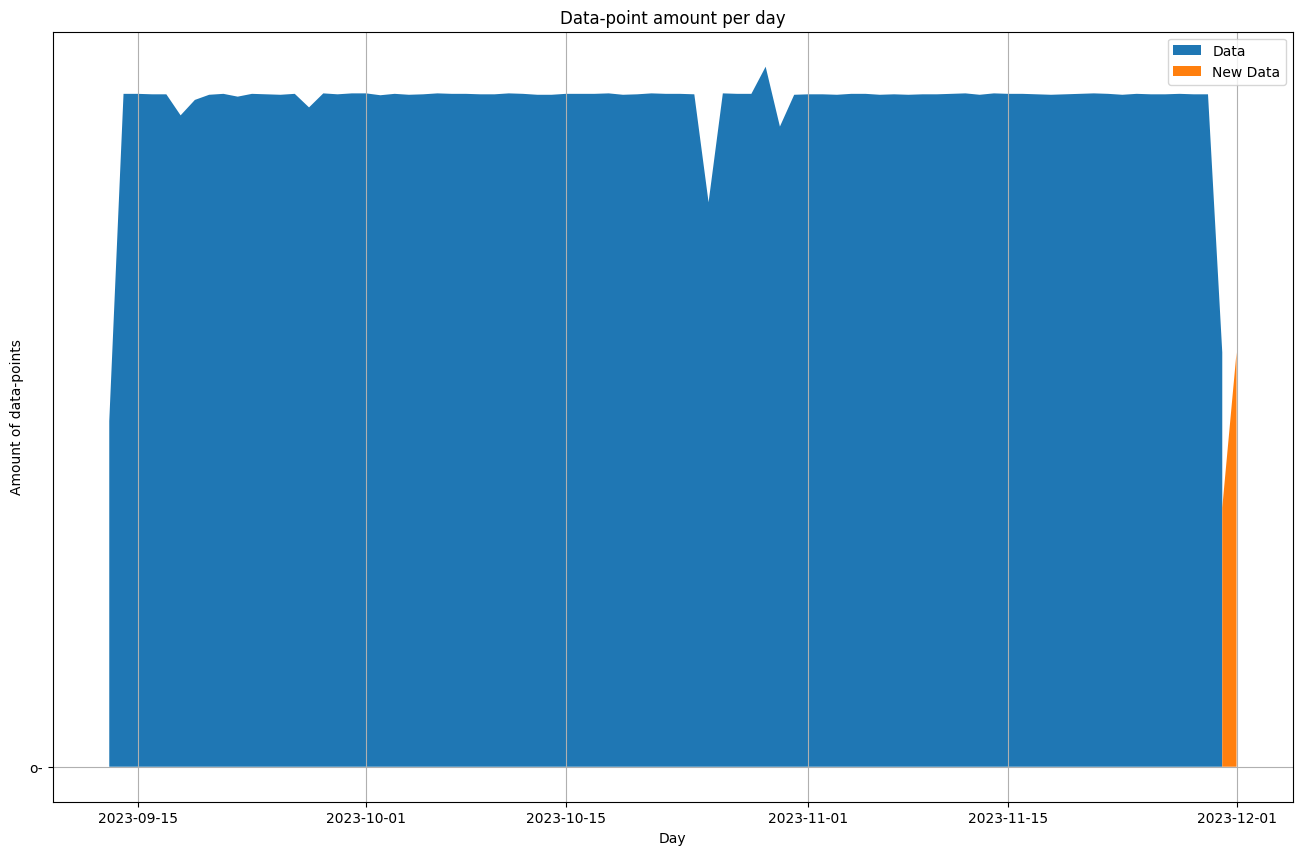

In [16]:
date_counts = df_chopper['Zeitstempel'].dt.date.value_counts()
date_counts = date_counts.sort_index()

date_counts_2 = new_df['Zeitstempel'].dt.date.value_counts()
date_counts_2 = date_counts_2.sort_index()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[16, 10])
ax.set_title("Data-point amount per day")
ax.set_xlabel("Day")
ax.set_ylabel("Amount of data-points")
ax.fill_between(date_counts.index, date_counts, 'o-', label="Data")    #, c="blue"
ax.fill_between(date_counts_2.index, date_counts_2, 'o-', label="New Data") #c="red"
ax.grid()
ax.legend()

plt.savefig(f'{PATH} New Data.png', transparent=PLOT_TRANSPARENT)

### Manual Feature Extraction

**Classic Time-Depended Features**
- Month -> propably one-hot encoded
- Hour
- Working-Hour? -> More effective?
- Day of the week
- Week of month
- Week of year
- Work day or not
  - maybe similiar to "Day of the week"
- ~~Weekend or not~~
  - Better with Work day or not, there are holiday included
- ~~Holiday or not~~
  - Included in Work Day or not
- ~~Daylight savings or not~~
  - Propably not helpful
- Quarter of the year
  - If seasonal then helpful, here propably not
  - Propably encoded in month
- Season of the year
  - If seasonal then helpful, here propably not
  - Propably encoded in month

**Lag Features** -> not recommended in this usecase<br>
-> Information from the past for the future -> we didn't found a pattern in the data, this is problem not helpful
- Shift of active Power

**Rolling Features** -> not recommended in this usecase<br>
-> Information from the past for the future -> we didn't found a pattern in the data, this is problem not helpful<br>
- Forward rolling mean from Active Power -> therotically also other columns possible
  - Not a feature but could be used for the Target 
- Exponential weighted rolling mean from Active Power -> therotically also other columns possible
  - Not a feature but could be used for the Target 
- Expanding Window feature

**Other Features**
- ~~Temperature~~
  - Analysis seems to show that there is no connection
- ~~Predicition~~
  - - Analysis seems to show that there is no connection
- Mass Flow / Conveyor Active Power
  - Have to been calculated and predicted
- ~~High-Correltion (between Chopper and Conveyor)~~
  - Syon wanted to do it

In [62]:
class Feature(Enum):
    HOUR = "HOUR"
    WORKING_HOUR = "WORKING_HOUR"
    MONTH = "MONTH"
    MONTH_ONE_HOT_ENCODED = "MONTH_ONE_HOT_ENCODED"
    DAY_OF_THE_YEAR = "DAY_OF_THE_YEAR"
    DAY_OF_THE_WEEK = "DAY_OF_THE_WEEK"
    WEEK_OF_THE_YEAR = "WEEK_OF_THE_YEAR"
    WEEK_OF_THE_MONTH = "WEEK_OF_THE_MONTH"
    WORKING_DAY = "WORKING_DAY"
    QUARTER = "QUARTER"
    SEASON = "SEASON"
    LAG_1 = "LAG_1"
    LAG_7 = "LAG_7"
    ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT = "ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT"
    ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT = "ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT"
    ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT = "ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT"
    EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT = "EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT"
    EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT = "EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT"
    EXPAND_SUM = "EXPAND_SUM"
    MASS_FLOW = "MASS_FLOW"

In [18]:
def add_other_months(months_df):
    months_df = months_df.copy()
    new_df = pd.DataFrame(index=months_df.index)
    missing_months = []
    for i in range(1, 13):
        if f"MONTH_{i}" not in months_df.columns.to_list():
            missing_months += [f"MONTH_{i}"]
            new_df[f"MONTH_{i}"] = False
    months_df = pd.concat([months_df, new_df], axis=1)

    # sort columns
    rename_dict = dict()
    for cur_month in months_df.columns:
        n = int(cur_month.split("_")[1])
        rename_dict[cur_month] = f"MONTH_{n:02}"
    months_df = months_df.rename(columns=rename_dict)
    return months_df.sort_index(axis=1)

In [60]:
def week_of_month(date):
    first_day = date.replace(day=1)
    cur_day = date.day
    adjusted_cur_day = cur_day + first_day.weekday()
    return int(np.ceil(adjusted_cur_day/7.0))

def get_season(date):
    if date.month in [3, 4, 5]:
        return 'Frühling'
    elif date.month in [6, 7, 8]:
        return 'Sommer'
    elif date.month in [9, 10, 11]:
        return 'Herbst'
    else:
        return 'Winter'

In [38]:
def get_mass_flow(cur_active_power):
    p1 = (MIN_MAX_MASS_FLOW_CONVEYOR[0], MIN_MAX_PERFORMANCE_CONVEYOR[0])
    p2 = (MIN_MAX_MASS_FLOW_CONVEYOR[1], MIN_MAX_PERFORMANCE_CONVEYOR[1])
    slope = (p2[1] - p1[1])/(p2[0] - p1[0])

    if cur_active_power > MIN_MAX_PERFORMANCE_CONVEYOR[1]:
        cur_active_power = MIN_MAX_PERFORMANCE_CONVEYOR[1]
    elif cur_active_power < MIN_MAX_PERFORMANCE_CONVEYOR[0]:
        cur_active_power = MIN_MAX_PERFORMANCE_CONVEYOR[0]
    res = (cur_active_power-MIN_MAX_PERFORMANCE_CONVEYOR[0])/slope
    return res 

def create_mass_flow_feature(train_df_conveyor_belt:pd.DataFrame):
    # create feature
    used_features = [Feature.HOUR, Feature.MONTH, Feature.WORKING_DAY]
                    #Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT,
                    #Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT]

    train_df, application_df = create_features(train_df_conveyor_belt, used_features)

    # train model
    #model = SVR(kernel="rbf")
    model = RandomForestRegressor()
    model = model.fit(train_df, train_df_conveyor_belt[TARGET])

    result = pd.DataFrame(model.predict(application_df), columns=["Prediction"], index=application_df.index)
    result["MASS_FLOW"] = result["Prediction"].apply(get_mass_flow)
    return result.loc[:, "MASS_FLOW"]

In [64]:
def create_features(data:pd.DataFrame, features:list, application_df=None):
    train_df = data.copy()
    if application_df == None:
        application_df = create_future_data(train_df, should_append=False)
        complete_df = create_future_data(train_df, should_append=True)
    else:
        complete_df = pd.concat([train_df, application_df], axis=0)
    split_date = train_df.index.max()
    list_features = []

    #########################
    ### CREATE TRAIN DATA ###
    #########################
    if Feature.HOUR in features:
        train_df[Feature.HOUR.value] = train_df["Zeitstempel"].dt.hour
        list_features += [Feature.HOUR.value]

    if Feature.WORKING_HOUR in features:
        train_df[Feature.WORKING_HOUR.value] = train_df["Zeitstempel"].dt.hour.between(5, 20)
        list_features += [Feature.WORKING_HOUR.value]

    if Feature.MONTH in features:
        train_df[Feature.MONTH.value] = train_df["Zeitstempel"].dt.month
        list_features += [Feature.MONTH.value]

    if Feature.MONTH_ONE_HOT_ENCODED in features:
        months = pd.get_dummies(train_df.index.month, drop_first=False, prefix="MONTH")
        months.index = train_df.index
        months = add_other_months(months)
        train_df = pd.concat([train_df, months], axis=1)
        list_features += months.columns.to_list()

    if Feature.DAY_OF_THE_YEAR in features:
        train_df[Feature.DAY_OF_THE_YEAR.value] = train_df["Zeitstempel"].dt.dayofyear
        list_features += [Feature.DAY_OF_THE_YEAR.value]

    if Feature.DAY_OF_THE_WEEK in features:
        train_df[Feature.DAY_OF_THE_WEEK.value] = train_df["Zeitstempel"].dt.dayofweek
        list_features += [Feature.DAY_OF_THE_WEEK.value]

    if Feature.WEEK_OF_THE_YEAR in features:
        train_df[Feature.WEEK_OF_THE_YEAR.value] = train_df["Zeitstempel"].dt.isocalendar().week
        list_features += [Feature.WEEK_OF_THE_YEAR.value]

    if Feature.WEEK_OF_THE_MONTH in features:
        train_df[Feature.WEEK_OF_THE_MONTH.value] = train_df["Zeitstempel"].apply(week_of_month)
        list_features += [Feature.WEEK_OF_THE_MONTH.value]

    if Feature.WORKING_DAY in features:
        train_df[Feature.WORKING_DAY.value] = train_df["Zeitstempel"].dt.strftime('%d.%m.%Y').apply(is_work_day)
        list_features += [Feature.WORKING_DAY.value]

    if Feature.QUARTER in features:
        train_df[Feature.QUARTER.value] = train_df["Zeitstempel"].dt.quarter
        list_features += [Feature.QUARTER.value]

    if Feature.SEASON in features:
        train_df[Feature.SEASON.value] = train_df["Zeitstempel"].apply(get_season)
        list_features += [Feature.SEASON.value]

    if Feature.LAG_1 in features:
        train_df[Feature.LAG_1.value] = train_df[TARGET].shift(ONE_DAY).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.LAG_1.value]

    if Feature.LAG_7 in features:
        train_df[Feature.LAG_7.value] = train_df[TARGET].shift(ONE_WEEK).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.LAG_7.value]

    if Feature.ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT in features:
        train_df[Feature.ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT.value] = train_df[TARGET].rolling(window=ONE_DAY).mean().shift(ONE_DAY).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT.value]

    if Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT in features:
        train_df[Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT.value] = train_df[TARGET].rolling(window=ONE_HOUR).mean().shift(ONE_DAY).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT.value]

    if Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT in features:
        train_df[Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT.value] = train_df[TARGET].rolling(window=ONE_HOUR).mean().shift(ONE_WEEK).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT.value]

    if Feature.EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT in features:
        train_df[Feature.EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT.value] = train_df[TARGET].ewm(span=len(train_df.index)).mean().shift(ONE_DAY).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT.value]

    if Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT in features:
        train_df[Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT.value] = train_df[TARGET].ewm(span=len(train_df.index)).mean().shift(ONE_WEEK).bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT.value]

    if Feature.EXPAND_SUM in features:
        train_df[Feature.EXPAND_SUM.value] = train_df[TARGET].expanding().sum().bfill().ffill().fillna(train_df[TARGET].mean())
        list_features += [Feature.EXPAND_SUM.value]

    if Feature.MASS_FLOW in features:
        train_df[Feature.MASS_FLOW.value] = train_df[TARGET].apply(get_mass_flow)
        list_features += [Feature.MASS_FLOW.value]

    ###############################
    ### CREATE APPLICATION DATA ###
    ###############################
    if Feature.HOUR in features:
        application_df[Feature.HOUR.value] = application_df["Zeitstempel"].dt.hour

    if Feature.WORKING_HOUR in features:
        application_df[Feature.WORKING_HOUR.value] = application_df["Zeitstempel"].dt.hour.between(5, 20)

    if Feature.MONTH in features:
        application_df[Feature.MONTH.value] = application_df["Zeitstempel"].dt.month

    if Feature.MONTH_ONE_HOT_ENCODED in features:
        months = pd.get_dummies(application_df.index.month, drop_first=False, prefix="MONTH")
        months.index = application_df.index
        months = add_other_months(months)
        application_df = pd.concat([application_df, months], axis=1)

    if Feature.DAY_OF_THE_YEAR in features:
        application_df[Feature.DAY_OF_THE_YEAR.value] = application_df["Zeitstempel"].dt.dayofyear

    if Feature.DAY_OF_THE_WEEK in features:
        application_df[Feature.DAY_OF_THE_WEEK.value] = application_df["Zeitstempel"].dt.dayofweek

    if Feature.WEEK_OF_THE_YEAR in features:
        application_df[Feature.WEEK_OF_THE_YEAR.value] = application_df["Zeitstempel"].dt.isocalendar().week

    if Feature.WEEK_OF_THE_MONTH in features:
        application_df[Feature.WEEK_OF_THE_MONTH.value] = application_df["Zeitstempel"].apply(week_of_month)

    if Feature.WORKING_DAY in features:
        application_df[Feature.WORKING_DAY.value] = application_df["Zeitstempel"].dt.strftime('%d.%m.%Y').apply(is_work_day)

    if Feature.QUARTER in features:
        application_df[Feature.QUARTER.value] = application_df["Zeitstempel"].dt.quarter

    if Feature.SEASON in features:
        application_df[Feature.SEASON.value] = application_df["Zeitstempel"].apply(get_season)

    if Feature.LAG_1 in features:
        application_df[Feature.LAG_1.value] = complete_df[TARGET].shift(ONE_DAY).bfill().ffill().fillna(complete_df[TARGET].mean()).loc[complete_df.index > split_date]

    if Feature.LAG_7 in features:
        application_df[Feature.LAG_7.value] = complete_df[TARGET].shift(ONE_WEEK).bfill().ffill().fillna(complete_df[TARGET].mean()).loc[complete_df.index > split_date]

    if Feature.ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT in features:
        application_df[Feature.ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT.value] = complete_df[TARGET].rolling(window=ONE_DAY)\
                                                                                                    .mean()\
                                                                                                    .shift(ONE_DAY)\
                                                                                                    .bfill().ffill()\
                                                                                                    .fillna(complete_df[TARGET].mean())\
                                                                                                    .loc[complete_df.index > split_date]

    if Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT in features:
        application_df[Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT.value] = complete_df[TARGET].rolling(window=ONE_HOUR)\
                                                                                                    .mean()\
                                                                                                    .shift(ONE_DAY)\
                                                                                                    .bfill().ffill()\
                                                                                                    .fillna(complete_df[TARGET].mean())\
                                                                                                    .loc[complete_df.index > split_date]

    if Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT in features:
        application_df[Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT.value] = complete_df[TARGET].rolling(window=ONE_HOUR)\
                                                                                                    .mean()\
                                                                                                    .shift(ONE_WEEK)\
                                                                                                    .bfill().ffill()\
                                                                                                    .fillna(complete_df[TARGET].mean())\
                                                                                                    .loc[complete_df.index > split_date]

    if Feature.EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT in features:
        application_df[Feature.EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT.value] = complete_df[TARGET].ewm(span=len(complete_df.index))\
                                                                                                    .mean()\
                                                                                                    .shift(ONE_DAY)\
                                                                                                    .bfill().ffill()\
                                                                                                    .fillna(complete_df[TARGET].mean())\
                                                                                                    .loc[complete_df.index > split_date]
                                                
    if Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT in features:
        application_df[Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT.value] = complete_df[TARGET].ewm(span=len(complete_df.index))\
                                                                                                    .mean()\
                                                                                                    .shift(ONE_WEEK)\
                                                                                                    .bfill().ffill()\
                                                                                                    .fillna(complete_df[TARGET].mean())\
                                                                                                    .loc[complete_df.index > split_date]

    if Feature.EXPAND_SUM in features:
        application_df[Feature.EXPAND_SUM.value] = complete_df[TARGET].expanding().sum().fillna(complete_df[TARGET].mean()).loc[complete_df.index > split_date]

    if Feature.MASS_FLOW in features:
        application_df[Feature.MASS_FLOW.value] = create_mass_flow_feature(df_conveyor)

    return train_df.loc[:, list_features], application_df.loc[:, list_features]

In [65]:
used_features = [Feature.HOUR, 
                    Feature.MONTH, 
                    Feature.DAY_OF_THE_WEEK, 
                    Feature.WORKING_DAY, 
                    Feature.LAG_1, 
                    Feature.LAG_7,
                    Feature.EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT, 
                    Feature.EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT,
                    Feature.ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT,
                    Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT,
                    Feature.ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT,
                    Feature.EXPAND_SUM,
                    Feature.DAY_OF_THE_YEAR,
                    Feature.QUARTER,
                    Feature.SEASON,
                    Feature.WORKING_HOUR,
                    Feature.WEEK_OF_THE_YEAR,
                    Feature.WEEK_OF_THE_MONTH]

train_df, application_df = create_features(df_chopper, used_features)
application_df

,HOUR,WORKING_HOUR,MONTH,DAY_OF_THE_YEAR,DAY_OF_THE_WEEK,WEEK_OF_THE_YEAR,WEEK_OF_THE_MONTH,WORKING_DAY,QUARTER,SEASON,LAG_1,LAG_7,ROLLING_MEAN_1_DAY_WINDOWSIZE_1_DAY_SHIFT,ROLLING_MEAN_1_HOUR_WINDOWSIZE_1_DAY_SHIFT,ROLLING_MEAN_1_HOUR_WINDOWSIZE_7_DAY_SHIFT,EXPONENTIAL_WEIGHTED_MEAN_1_DAY_SHIFT,EXPONENTIAL_WEIGHTED_MEAN_7_DAY_SHIFT,EXPAND_SUM
2023-11-30 14:46:00,14,True,11,334,3,48,5,1,4,Herbst,29000.0,29000.0,54411.111111,55950.000000,130533.333333,51879.507559,54846.055270,5.859195e+09
2023-11-30 14:47:00,14,True,11,334,3,48,5,1,4,Herbst,29000.0,28000.0,54139.583333,46850.000000,130500.000000,51879.037436,54845.488161,5.859195e+09
2023-11-30 14:48:00,14,True,11,334,3,48,5,1,4,Herbst,28000.0,29000.0,53784.027778,46816.666667,130483.333333,51878.546778,54844.942190,5.859195e+09
2023-11-30 14:49:00,14,True,11,334,3,48,5,1,4,Herbst,29000.0,24000.0,53513.888889,44466.666667,130500.000000,51878.076678,54844.290611,5.859195e+09
2023-11-30 14:50:00,14,True,11,334,3,48,5,1,4,Herbst,30000.0,31000.0,53418.750000,44516.666667,121450.000000,51877.627137,54843.786918,5.859195e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01 14:41:00,14,True,12,335,4,48,1,1,4,Winter,0.0,30000.0,49481.597222,0.000000,25400.000000,51814.831964,54445.378040,5.859195e+09
2023-12-01 14:42:00,14,True,12,335,4,48,1,1,4,Winter,0.0,24000.0,49458.680556,0.000000,25366.666667,51813.771681,54444.738073,5.859195e+09
2023-12-01 14:43:00,14,True,12,335,4,48,1,1,4,Winter,0.0,28000.0,49443.402778,0.000000,25450.000000,51812.711424,54444.182202,5.859195e+09
2023-12-01 14:44:00,14,True,12,335,4,48,1,1,4,Winter,0.0,28000.0,49423.958333,0.000000,25500.000000,51811.651191,54443.626344,5.859195e+09


### Result

-> The Mass-Flow Feature can be improved by using a NN for prediction (enough data propably exist)

We have succefully created several Features and in a way that we can use it in future

### Source

- https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0
- https://dotdata.com/blog/practical-guide-for-feature-engineering-of-time-series-data/
- https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/
- https://towardsdatascience.com/three-approaches-to-feature-engineering-for-time-series-2123069567be
- https://medium.com/codex/simple-moving-average-and-exponentially-weighted-moving-average-with-pandas-57d4a457d363
- https://medium.com/almabetter/feature-engineering-for-time-series-problem-f17946960ea0
- https://medium.com/almabetter/feature-engineering-for-time-series-problem-79231cd8d14e

---